# Modeling Personal Loan Delinquency with LendingClub Data

Our project focuses on the domain of peer-to-peer consumer lending. The task is to model credit risk on personal loans, more precisely to evaluate the probability of default or delinquency of borrowers during their loan period.

We explored different ways to model the loans, all based on the idea of modeling the loans as Markov Processes, with discrete states that we present in the next section, and discrete timestamps (data is collected monthly).

We discovered that modelling sequential models is not an easy task given the tools of Probabilistic Programming, therefore we tried various way to build models and perform inference, and compared each of them.

## Data

In [1]:
from utils.utils import load_dataframe, preprocess, split_data
from utils.models import build_mle_matrix, build_mc_no_priors, build_mc_with_priors
from utils.inference import compute_mle, infer_mc_no_priors, infer_mc_with_priors
from utils.criticism import sample_mle, plot_sampled_lengths

import numpy as np

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
df = load_dataframe()

Loading raw data from cache...
Retrieved 40,263,987 rows, 4 columns in 4.89 seconds


Our variable of interest is called `loan_status` which has eight possible states. These are the Loan Status Descriptions based on the LendingClub's [website](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-):

- **Issued**: New loan that has passed all LendingClub reviews, received full funding, and has been issued.

- **Current**: Loan is up to date on all outstanding payments. 

- **In Grace Period**: Loan payment is late, but within the 15-day grace period.
 
- **Late (16-30)**: Loan is late, past the grace period, hasn't been current for 16 to 30 days.
 
- **Late (31-120)**: Loan has not been current for 31 to 120 days.
 
- **Charged Off**: Loan for which there is no longer a reasonable expectation of further payments. Charge Off typically occurs when a loan is 120 days or more past due and there is no reasonable expectation of sufficient payment to prevent the charge off. Loans for which borrowers have filed for bankruptcy may be charged off earlier.

- **Default**: Loan has not been current for an extended period of time. Charged off and default states are similar, yet different. [TODO explain]

- **Fully paid**: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

In [3]:
df = preprocess(df)

Mapping column names...
Loading preprocessed data from cache...
Retrieved 27,636,875 rows, 4 columns in 3.09 seconds


In [4]:
x_train, x_test = split_data(df)

Loading split data from cache...
Retrieved 1,486,122 rows, 36 columns in 0.87 seconds
Train: (1337551, 36) | Test: (148571, 36)


## Experiment 1: Markov Model with Maximum Likelihood Estimates

We start with a simple model which is a Markov Model, which is stationary and homogeneous: the transitions between states are the same for all loans, and don't vary with time. We will keep this model for several experiments, as inference can be quite challenging even on this simpel model.

Even though we want to solve the problem from a Bayesian perspective, our first idea is to estimate the model with MLE estimates, which are easy to obtain and give us a robust baseline.

### 1.1 Model

We can easily derive that the MLE estimates for such a model are simply the empirical frequencies of each transition, therefore all we need to do is to build a count matrix where we count each type of transition i => j between two states i,j.

In [5]:
realized_transitions = build_mle_matrix(df)

Loading transitions data from cache...
Retrieved 8 rows, 8 columns in 0.02 seconds


In [6]:
realized_transitions

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0,0,0,0,0,0,0,0
Current,774,24450170,3,707161,5831,0,160357,62006
Default,28843,147,2206,71,0,0,4,506
Fully Paid,0,0,0,8063,12,0,101,72
In Grace Period,0,276,0,11,22,0,59,41
Issued,0,17206,0,670,1,0,38,1
Late (16-30 days),4548,32374,0,2066,257,0,13413,119613
Late (31-120 days),105932,25398,29748,2138,56,0,3292,332463


### 1.2 Inference

Now that we have built a count matrix, we just take empirical frequencies to get our estimates:

In [7]:
mle = compute_mle(realized_transitions)

In [8]:
mle

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Current,0.00,0.96,0.00,0.03,0.00,0.0,0.01,0.00
Default,0.91,0.00,0.07,0.00,0.00,0.0,0.00,0.02
Fully Paid,0.00,0.00,0.00,0.98,0.00,0.0,0.01,0.01
In Grace Period,0.00,0.67,0.00,0.03,0.05,0.0,0.14,0.10
Issued,0.00,0.96,0.00,0.04,0.00,0.0,0.00,0.00
Late (16-30 days),0.03,0.19,0.00,0.01,0.00,0.0,0.08,0.69
Late (31-120 days),0.21,0.05,0.06,0.00,0.00,0.0,0.01,0.67


Note that these probabilities are true probabilities, except for Charged Off: this is a "sink state", therefore there is no possible next state, hence the row of 0.

### 1.3 Criticism

**Values of the estimates:**

We can see that a lot of the MLE estimates reflect our expectations, for example we can see that:
- A loan which is 'Current' is much more likely to stay 'Current' the next month than any other state transition.
- Some states are not reachable from certain states, for example once Charged Off, a loan cannot go to any other state, because LC shuts down the loan completely. Similarly, a loan cannot transition from 'Current' to 'Late (31-120)', because first it has to go to either Grace Period or 'Late (16-30)', since we are measuring data each month.

We can also see the limits of our model and of these estimates:
- TODO

One trick that is usally done on MLE estimates for Markov Models is "add-one smoothing" which sets all the probabilities to a small value different than 0, to account for possible transitions that haven't been observed in our data. Since our dataset is very large and the number of states is small, we assume that it is not the case in our case: if a transition has never been observed, we consider that it is not possible.

**Sampling:**

In [9]:
sample_mle(mle)

['Issued',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Fully Paid']

We can now use these estimates to generate some trajectories. We start as 'issued' and keep generating transitions for a period of 36 months, except if we reach 'Charged Off' which is a "sink state".

In [28]:
sample_mle(mle)

['Issued',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Late (16-30 days)',
 'Late (16-30 days)',
 'Late (16-30 days)',
 'Current',
 'Current']

By sampling, we can see limitations of the model itself, for example:
- For Late (31-120), our model doesn't take into account how long has the loan spent in that state. But we do know that after being in that state 4 times, the probability of going to Charged Off is almost 1.

**Looking at statistics based on generated samples:**

One thing we can do is to sample many times and look at the average length of a loan, and compare that to the empirical value in the data:

In [9]:
sampled_trajectories = [sample_mle(mle) for _ in range(10000)]

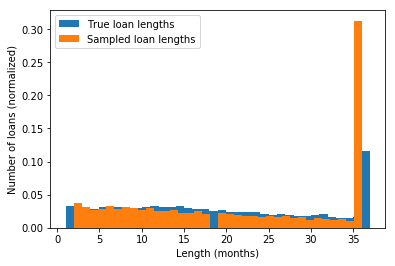

Average length of sampled loans: 21.54 months
Average length of true loans: 18.17 months


In [10]:
plot_sampled_lengths(sampled_trajectories, df)

### TODO re-run MLE with extrapolated MC

## Experiment 2: Stationary Markov Chain with Priors

In [5]:
chain_len = max(df.age_of_loan)
n_states = df.loan_status.unique().shape[0]

### 2.1 Model

In [48]:
batch_size = 1000

In [49]:
x, pi_0, pi_T = build_mc_with_priors(n_states, chain_len, batch_size)

### 2.2 Inference (Batch)

@Basil: I load models and inference like this so that I can reload them without restarting the kernel: (you can reload a module but can't reload a function): 

In [50]:
import utils.models, utils.inference

In [51]:
from importlib import reload
reload(utils.models)
reload(utils.inference)

<module 'utils.inference' from '/Users/jeromekafrouni/Documents/Cours/Columbia/Cours/Semestre 3/COMS 6998 Prob Programming/Project/lending-club-analysis/final-project/utils/inference.py'>

**Parameter tuning**

I tried multiple values for n_samples:
- 5 = what we had initially, somewhat converges
- 1000 = too high, blows up the memory 
- 100 = still goes to NaN with default optimizer; with custom optimizer, doesn't seem to help that much
=> setting to 10 for now

Optimizer:
- lr = 0.01 too high, goes to NaN
- anything higher than 0.005 goes to NaN eventually
- 0.005 what he had so far
- 0.001 not much difference
- adding exponential decay of the lr (what's done by default when not specifying lr) doesn't help either

n_epochs:
- Have been using 10 so far

**TODO:** write down the KLqp loss; think about kl_scaling argument??

In [52]:
inferred_matrix, sess, qpi_0, qpi_T = utils.inference.infer_mc_with_priors(
    x_train, x, pi_0, pi_T, n_states, chain_len, batch_size, lr=0.005)

13300/13370 [ 99%] █████████████████████████████  ETA: 0s | Loss: 68652.266

In [53]:
inferred_matrix

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0.15,0.09,0.10,0.12,0.09,0.17,0.11,0.18
Current,0.12,0.19,0.12,0.08,0.11,0.15,0.12,0.11
Default,0.14,0.08,0.16,0.14,0.11,0.17,0.08,0.12
Fully Paid,0.13,0.10,0.08,0.15,0.20,0.13,0.13,0.09
In Grace Period,0.10,0.13,0.18,0.11,0.12,0.15,0.09,0.12
Issued,0.16,0.11,0.07,0.10,0.14,0.08,0.16,0.19
Late (16-30 days),0.09,0.13,0.16,0.09,0.21,0.15,0.09,0.09
Late (31-120 days),0.14,0.15,0.12,0.18,0.10,0.15,0.09,0.07


### 3.3 Criticism

## Experiment 3: Stationary Markov Chain with Priors, other implementation

= Experiment 2 with TFP's code

In [55]:
from importlib import reload
reload(utils.models)
reload(utils.inference)

<module 'utils.inference' from '/Users/jeromekafrouni/Documents/Cours/Columbia/Cours/Semestre 3/COMS 6998 Prob Programming/Project/lending-club-analysis/final-project/utils/inference.py'>

In [56]:
model, pi_0_2, pi_T_2 = utils.models.build_mc_with_priors_2(n_states, chain_len, batch_size=100)

In [57]:
inferred_matrix_2, sess_2, qpi_0_2, qpi_T_2 = utils.inference.infer_mc_with_priors_2(
    x_train, model, pi_0_2, pi_T_2, n_states, chain_len, batch_size=100)

13300/13375 [ 99%] █████████████████████████████  ETA: 1s | Loss: 279.274

In [89]:
with sess.as_default():
    inferred_qpi_T_2 = sess_2.run(qpi_T_2.mean())

In [21]:
import pandas as pd

In [58]:
inferred_matrix_2

,0,1,2,3,4,5,6,7
0,0.426628,0.048637,0.062605,0.055921,0.089832,0.091196,0.178470,0.046710
1,0.011596,0.891086,0.013478,0.020718,0.016596,0.016312,0.016876,0.013338
2,0.044410,0.170685,0.161403,0.112421,0.074925,0.211061,0.095809,0.129287
3,0.038578,0.067461,0.033687,0.620236,0.063591,0.059497,0.060069,0.056881
4,0.081323,0.236946,0.074473,0.089925,0.106642,0.134686,0.131970,0.144035
5,0.158048,0.226050,0.075840,0.119560,0.110130,0.171880,0.080624,0.057868
6,0.100323,0.095742,0.154575,0.205999,0.086672,0.103454,0.133485,0.119748
7,0.103088,0.083031,0.178755,0.054310,0.135737,0.141547,0.080839,0.222694


In [8]:
mle

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Current,0.00,0.96,0.00,0.03,0.00,0.0,0.01,0.00
Default,0.91,0.00,0.07,0.00,0.00,0.0,0.00,0.02
Fully Paid,0.00,0.00,0.00,0.98,0.00,0.0,0.01,0.01
In Grace Period,0.00,0.67,0.00,0.03,0.05,0.0,0.14,0.10
Issued,0.00,0.96,0.00,0.04,0.00,0.0,0.00,0.00
Late (16-30 days),0.03,0.19,0.00,0.01,0.00,0.0,0.08,0.69
Late (31-120 days),0.21,0.05,0.06,0.00,0.00,0.0,0.01,0.67


## Experiment 4: One categorical per timestamp in the chain

In [65]:
# TODO

## Experiment 5: Modeling counts of transitions, as a multinomial

In [66]:
# TODO

## Experiment 6: Segmenting the loans / mixture model

Probably won't have much time to do something decent, maybe we can do the segmentation "by hand" though, i.e. not in edwards...

In [67]:
# TODO